In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, accuracy_score

warnings.filterwarnings('ignore')

In [2]:
system_data = pd.read_csv('../b. Datasets/Industrial System Monitoring/Industrial System Monitoring.csv')

display(system_data.head(2))
display(system_data.tail(2))

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0


,temperature,pressure,vibration,humidity,equipment,location,faulty
7670,107.086485,23.754114,1.142522,23.967977,Compressor,Atlanta,1.0
7671,28.468054,66.588978,4.677368,79.670225,Turbine,Chicago,1.0


In [3]:
system_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [4]:
system_data.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [5]:
system_data.isna().sum().sum()

0

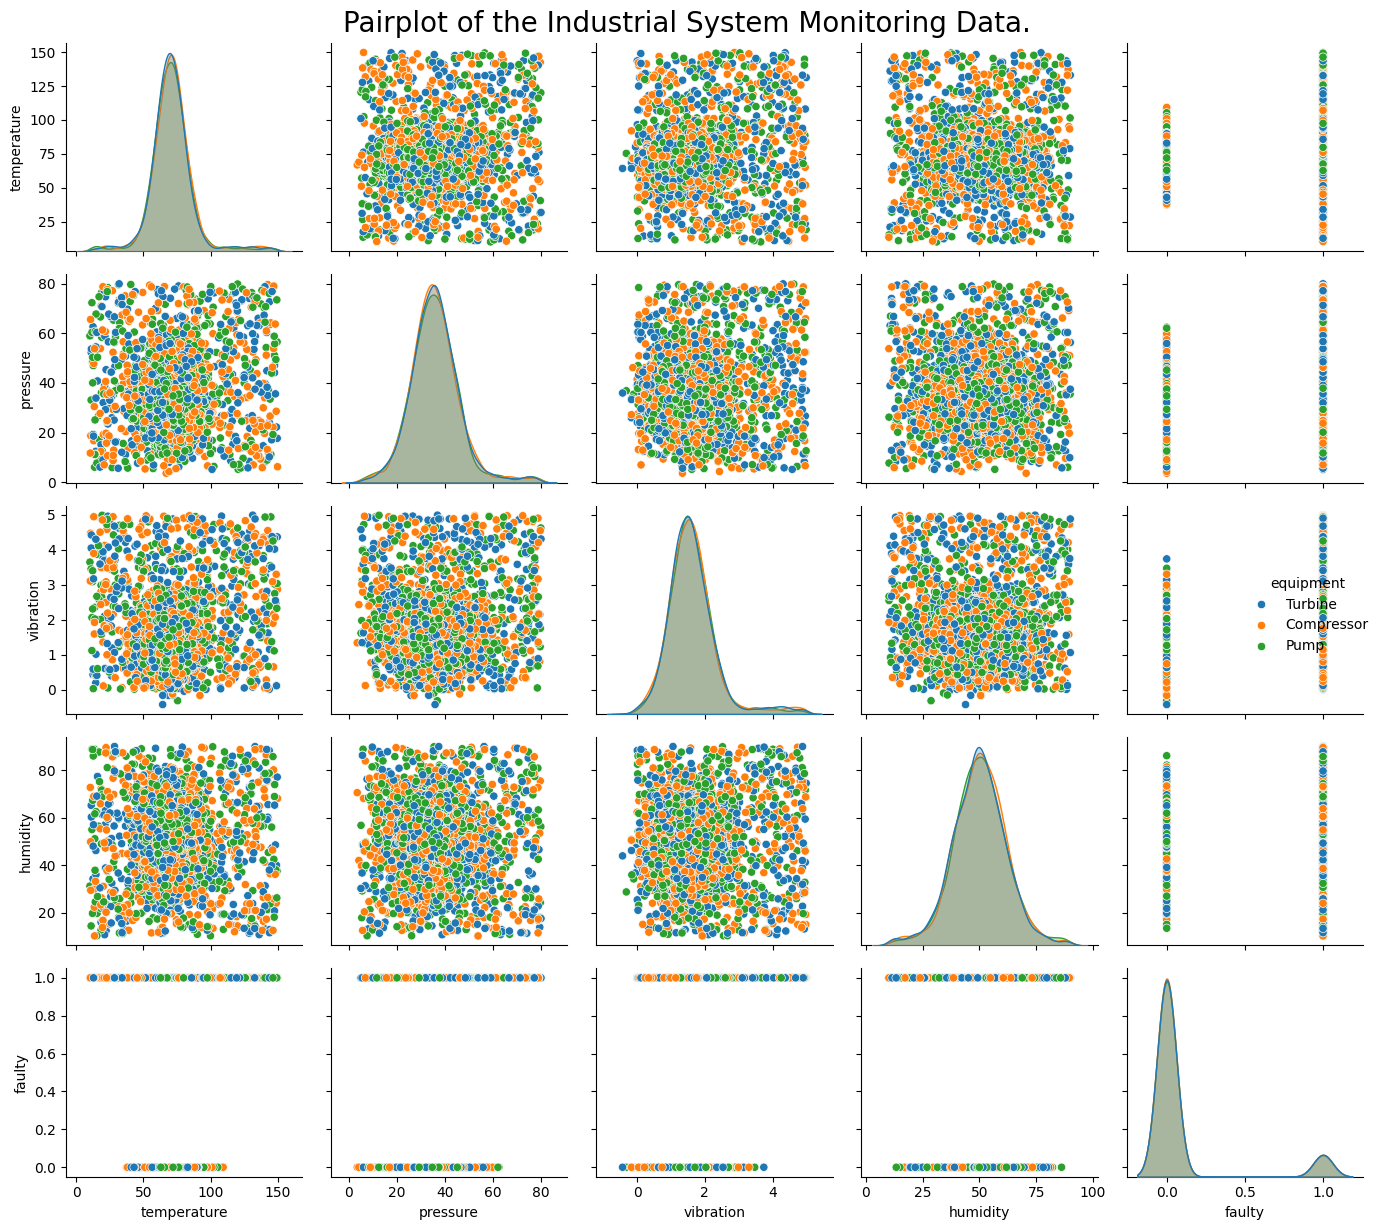

In [6]:
sns.pairplot(data=system_data, hue='equipment')
plt.suptitle("Pairplot of the Industrial System Monitoring Data.", fontsize=20)
plt.tight_layout()
plt.show()

<Axes: xlabel='faulty'>

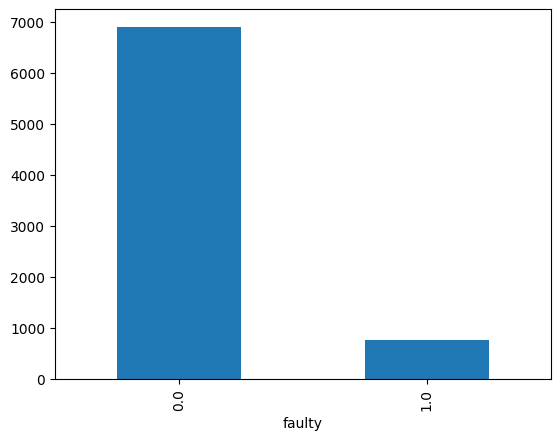

In [7]:
system_data.value_counts(subset='faulty').plot(kind='bar')

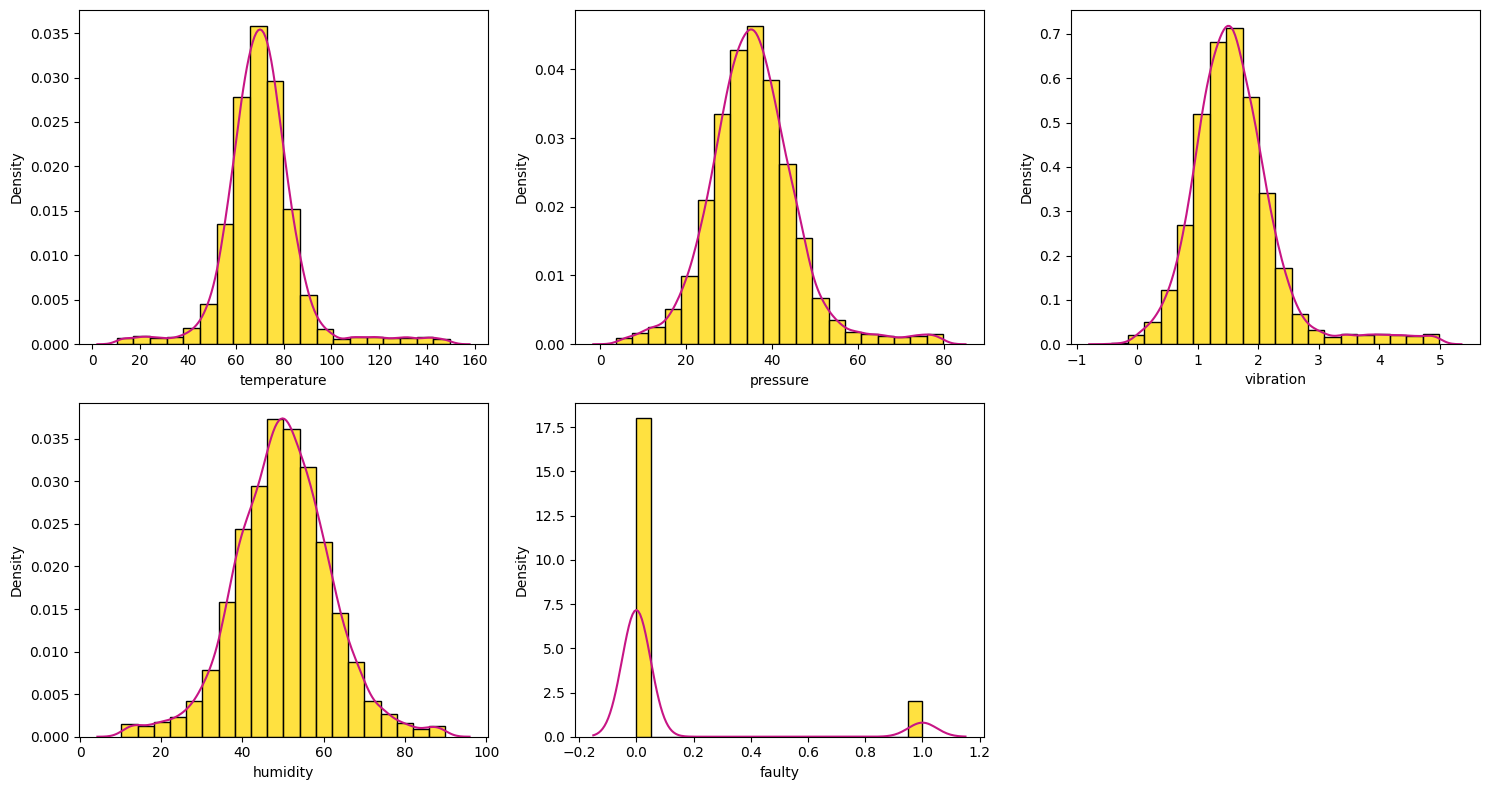

In [8]:
numerical_features = system_data.select_dtypes(include='number').columns
num_cols = 3
num_rows =  (len(numerical_features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows*4))
axes = axes.flatten()

for index, feature in enumerate(numerical_features):
    sns.histplot(data=system_data, stat='density', x=feature, ax=axes[index], color='#FFD700', bins=20)
    sns.kdeplot(data=system_data, x=feature, ax=axes[index], color='#C71585')

for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

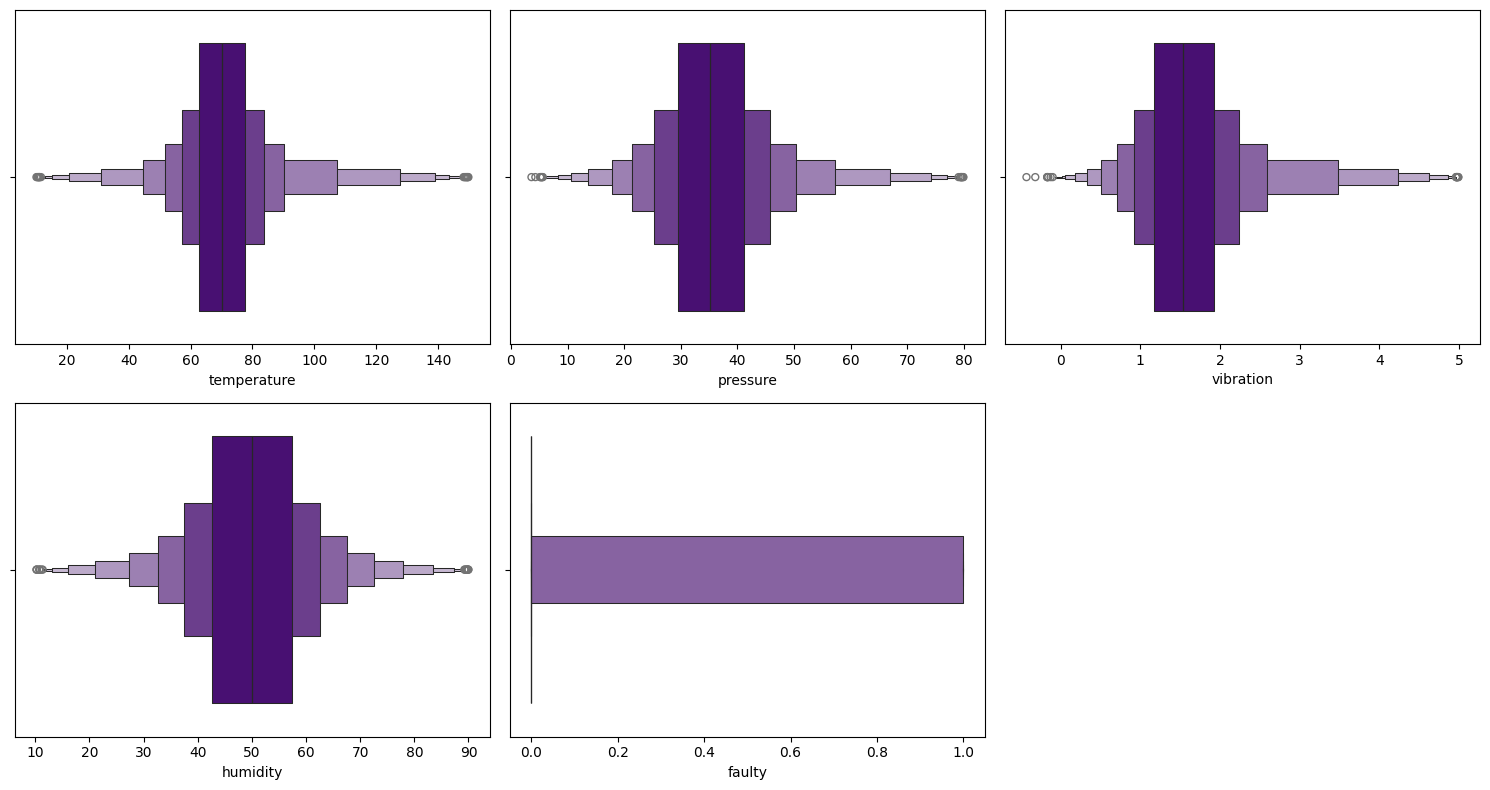

In [9]:
numerical_features = system_data.select_dtypes(include='number').columns
num_cols = 3
num_rows =  (len(numerical_features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows*4))
axes = axes.flatten()

for index, feature in enumerate(numerical_features):
    sns.boxenplot(data=system_data, x=feature, color='#4B0082', ax=axes[index])

for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
system_data.select_dtypes(include='number').std()

temperature    16.200059
pressure       10.381593
vibration       0.728560
humidity       11.841479
faulty          0.299985
dtype: float64

In [11]:
label_encoder = LabelEncoder()

for feature in system_data.select_dtypes(include='object').columns:
    system_data[feature] = label_encoder.fit_transform(system_data[feature])

In [12]:
display(system_data.head(2))
display(system_data.tail(2))

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,2,0,0.0
1,75.740712,22.954018,2.338095,41.867407,0,1,0.0


,temperature,pressure,vibration,humidity,equipment,location,faulty
7670,107.086485,23.754114,1.142522,23.967977,0,0,1.0
7671,28.468054,66.588978,4.677368,79.670225,2,1,1.0


In [13]:
X = system_data.drop(labels='faulty', axis=1)
y = system_data['faulty']

In [14]:
min_max_scaler = MinMaxScaler()
X_features = X.columns
X = pd.DataFrame(data=min_max_scaler.fit_transform(X), columns=X_features)
display(X.head(2))
display(X.tail(2))

,temperature,pressure,vibration,humidity,equipment,location
0,0.343641,0.280705,0.190950,0.444779,1.0,0.00
1,0.469594,0.253494,0.510504,0.396797,0.0,0.25


,temperature,pressure,vibration,humidity,equipment,location
7670,0.694422,0.263985,0.289867,0.172408,0.0,0.00
7671,0.130530,0.825629,0.942206,0.870697,1.0,0.25


In [15]:
smote = SMOTE(random_state=0)
X, y = smote.fit_resample(X, y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

display(X_train.head(2))
display(X_test.head(2))
display(y_train.head(2))
display(y_test.head(2))

,temperature,pressure,vibration,humidity,equipment,location
1559,0.380091,0.340192,0.269423,0.502902,0.5,0.00
4348,0.375165,0.243114,0.231732,0.636014,0.5,0.75


,temperature,pressure,vibration,humidity,equipment,location
12387,0.067870,0.136275,0.993740,0.759708,0.5,0.528594
13807,0.162162,0.067300,0.508588,0.716662,0.5,0.959856


1559    0.0
4348    0.0
Name: faulty, dtype: float64

12387    1.0
13807    1.0
Name: faulty, dtype: float64

In [17]:
search_space = {
    'C': (0.1, 1000.0, 'log-uniform'),
    'gamma': (1e-6, 1.0, 'log-uniform'),
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': (2, 5),
    'coef0': (0.0, 10.0)
}

stratified_k_fold_cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

svm_model = SVC()

opt = BayesSearchCV(svm_model, 
                    search_space, 
                    n_iter=10, 
                    random_state=0, 
                    n_jobs=-1, 
                    cv=stratified_k_fold_cv)

opt.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
              estimator=SVC(), n_iter=10, n_jobs=-1, random_state=0,
              search_spaces={'C': (0.1, 1000.0, 'log-uniform'),
                             'coef0': (0.0, 10.0), 'degree': (2, 5),
                             'gamma': (1e-06, 1.0, 'log-uniform'),
                             'kernel': ['linear', 'rbf', 'poly']})

In [18]:
y_test_pred = opt.predict(X_test)

In [19]:
print("Accuracy is ", round(accuracy_score(y_test, y_test_pred)*100, 2))

Accuracy is  93.05


Confusion Matrix:


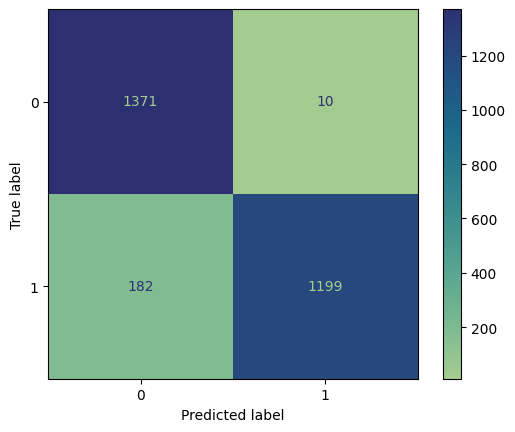

In [20]:
print("Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot(cmap='crest')

In [21]:
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      1381
         1.0       0.99      0.87      0.93      1381

    accuracy                           0.93      2762
   macro avg       0.94      0.93      0.93      2762
weighted avg       0.94      0.93      0.93      2762



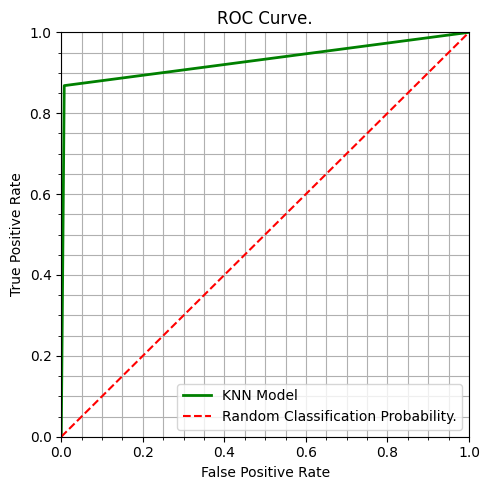

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='green', label="KNN Model", linewidth=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1.5, label='Random Classification Probability.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.minorticks_on()
plt.grid(which='both')
plt.title("ROC Curve.")
plt.legend()
plt.tight_layout()
plt.show()

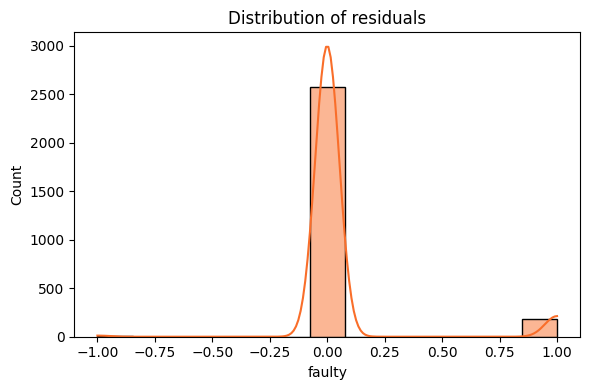

In [23]:
residuals = y_test - y_test_pred
plt.figure(figsize=(6, 4))
sns.histplot(data=residuals, kde=True, color='#F96E2A')
plt.title('Distribution of residuals')
plt.tight_layout()
plt.show()

In [24]:
residuals.skew()

2.961290881551752

In [25]:
permutation_importance = permutation_importance(opt, X_test, y_test, n_repeats=30, random_state=0)
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': permutation_importance.importances_mean
}).sort_values(by='importance', ascending=False)
display(feature_importance)

,feature,importance
0,temperature,0.128084
2,vibration,0.118561
1,pressure,0.096186
3,humidity,0.056927
4,equipment,0.002764
5,location,-0.001171


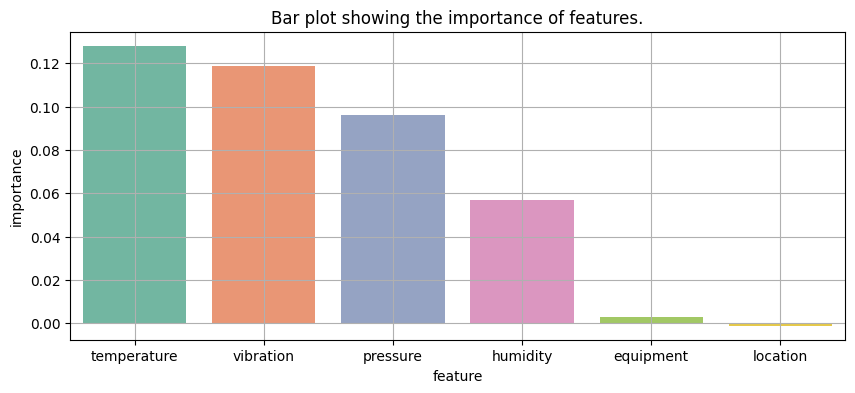

In [26]:
plt.figure(figsize=(10, 4))
sns.barplot(feature_importance, x='feature', y='importance', palette='Set2')
plt.title("Bar plot showing the importance of features.")
plt.grid()
plt.show()

In [27]:
submission_dataframe = pd.DataFrame({
    'Index': X_test.index,
    'Faulty?': y_test_pred
})
submission_dataframe.sort_values(by='Index', inplace=True)

In [28]:
submission_dataframe_file = '../d. Output Files/IndustrySystemMonitoring/IndustrySystemMonitoring_Prediction.csv'
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: IndustrySystemMonitoring_Prediction.csv
